In [ ]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum Enhanced Optimization for Radar and Communications Applications 


The Low Autocorrelation Binary Sequences (LABS) is an important and challenging optimization problem with applications related to radar, telecommunications, and other signal related applications. This CUDA-Q Academic module will focus on a clever quantum-enhanced hybrid method developed in a collaboration between Kipu Quantum, University of the Basque Country EHU, and NVIDIA for solving the LABS problem. (This notebook was jointly developed with input from all collaborators.)

Other CUDA-Q Academic modules like [Divide and Conquer MaxCut QAOA](https://github.com/NVIDIA/cuda-q-academic/tree/main/qaoa-for-max-cut) and [Quantum Finance](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/03_qchop.ipynb), demonstrate how quantum computing can be used outright to solve optimization problems. This notebook demonstrates a slightly different approach. Rather than considering QPUs as the tool to produce the final answer, it demonstrates how quantum can be used to enhance the effectiveness of leading classical methods.  

The benefits of such an approach were highlighted in [Scaling advantage with quantum-enhanced memetic tabu search for LABS](https://arxiv.org/html/2511.04553v1).  This notebook, co-created with the authors of the paper, will allow you to explore the findings of their research and write your own CUDA-Q code that builds a representative quantum-enhanced workflow for solving the LABS problem. Moreover, it will introduce advancements in counteradiabatic optimization techniques on which reduce the quantum resources required to run on a QPU.

**Prerequisites:** This lab assumes you have a basic knowledge of quantum computing, including operators, gates, etc.  For a refresher on some of these topics, explore the [Quick start to Quantum](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum) series.

**In this lab you will:**
* 1. Understand the LABS problem and its relation ot radar and communication applications.
* 2. Solve LABS classically with memetic tabu search and learn about the limitations of such methods.
* 3. Code a couteradiabatic algorithm using CUDA-Q to produce approximate solutions to the LABS problem.
* 4. Use the CUDA-Q results to seed your tabu search and understand the potential benefits of this approach.


**Terminology you will use:**
* Low autocorrelation of binary sequences (LABS)
* counteradiabatic optimization
* memetic-tabu search

**CUDA-Q Syntax you will use:**
* cudaq.sample()
* @cudaq.kernel
* ry(), rx(), rz(), x(), h() 
* x.ctrl()

Run the code below to initialize the libraries you will need.

In [ ]:
import cudaq
import numpy as np
from math import floor
import auxiliary_files.labs_utils as utils

## The LABS problem and applications

The **Low Autocorrelation Binary Sequences (LABS)** problem is fundamental to many applications, but originated with applications to radar. 

Consider a radar that monitors airport traffic.  The radar signal sent to detect incoming planes must have as much range as possible to ensure safe approaches are planned well in advance.  The range of a radar signal can be increased by sending a longer pulse.  However, in order to differentiate between multiple objects, pulses need to be short to provide high resolution. So, how do you handle situations where you need both?

One solution is a technique called pulse compression.  The idea is to send a long signal, but vary the phase at regular intervals such that the resolution is increased. Generally, the initial signal will encode a binary sequence of phase shifts, where each interval corresponds to a signal with a 0 or 180 degree phase shift. 

The tricky part is selecting an optimal encoding sequence.  When the signal returns, it is fed into a matched filter with the hope that a singular sharp peak will appear, indicating clear detection.  The autocorrelation of the original signal, or how similar the signal is to itself,  determines if a single peak or a messier signal with sidelobes will be detected. A signal should have high autocorrelation when overlayed on top of itself, but low autocorrelation when shifted with a lag. 

Consider the image below.  The signal on the left has a crisp single peak while the single on the right produces many undesirable sidelobes which can inhibit clear detection.  

<img src="images/quantum_enhanced_optimization_LABS/radar.png" width="800">


So, how do you select a good signal?   This is where LABS comes in, defining these questions as a binary optimization problem. Given a binary sequence of length $N$, $(s_1 \cdots s_N) \in {\pm 1}^N$, the goal is to minimize the following objective function.

$$ E(s) = \sum_{k=1}^{N-1} C_k^2 $$

Where $C_k$ is defined as. 

 $$C_k= \sum_{i=1}^{N-k} s_is_{i+k}$$


So, each $C_k$ computes how similar the original signal is to the shifted one for each offset value $k$.  To explore this more, try the interactive widget linked [here](https://nvidia.github.io/cuda-q-academic/interactive_widgets/labs_visualization.html).  See if you can select a very good and very poor sequence and see the difference for the case of $N=7$.

## Classical Solution of the LABS problem

The LABS problem is tricky to solve for a few reasons. First, the configuration space grows exponentially.  Second, underlying symmetries of the problem result in many degeneracies in the optimization landscape severely inhibiting local search methods. 

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 1:</h3>
    <p style="font-size: 16px; color: #333;">
Using the widget above, try to find some of the symmetries for the LABS problem. That is, for a fixed bitstring length, can you find patterns to produce the same energy with different pulse patterns.

Answer: Just by trying random sequences, I was able to rather quickly find that the best sequence is 1, 1, 1, -1, -1, 1, -1. The pattern also works backwards, meaning that it is symmetrical.
</div>

The best known performance for a classical optimization technique is Memetic Tabu search (MTS) which exhibits a scaling of $O(1.34^N)$.  The MTS algorithm is depicted below.  It begins with a randomly selected population of bitstrings and finds the best solution from them.  Then, a child is selected by sampling directly from or combining multiple bitstrings from the population.  The child is mutated with probability $p_{mutate}$ and then input to a tabu search, which performs a modified greedy local search starting from the child bitstring.  If the result is better than the best in the population, it is updated as the new leader and randomly replaces a  bitstring in the population.


<img src="images/quantum_enhanced_optimization_LABS/mts_algorithm.png" width="500">

Such an approach is fast, parallelizable, and allows for exploration with improved searching of the solution landscape.  

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 2:</h3>
    <p style="font-size: 16px; color: #333;">
Before exploring any quantum approach, get a sense for how MTS works by coding it yourself based generally on the figure above. Algorithms for the combine and mutate steps are provided below as used in the paper. You may need to research more specific details of the process, especially for how tabu search is performed. The MTS procedure should output and optimal bitstring and its energy.  Also, write a function to visualize the results including the energy distribution of the final population.
</div>



<img src="images/quantum_enhanced_optimization_LABS/combine_mutate.png" width="400">



In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

def calculate_energy(sequence):
    """
    Calculates the LABS energy (sum of squared autocorrelations).
    Sequence should be a numpy array of +1 and -1.
    """
    N = len(sequence)
    E = 0
    # Calculate autocorrelations for all lags k=1 to N-1
    for k in range(1, N):
        # element-wise multiplication of the sequence with its shifted self
        # s[0...N-1-k] * s[k...N-1]
        C_k = np.sum(sequence[:-k] * sequence[k:])
        E += C_k**2
    return E

def tabu_search(initial_sequence, max_evals=None):
    """
    Performs a local Tabu search starting from 'initial_sequence'.
    
    Args:
        initial_sequence: Numpy array of {-1, 1}
        max_evals: Optional override, otherwise uses paper default [N/2, 3N/2]
    
    Returns:
        best_sequence_found, best_energy_found
    """
    N = len(initial_sequence)
    
    # Current working solution
    curr_seq = initial_sequence.copy()
    curr_E = calculate_energy(curr_seq)
    
    # Global best found in this search
    best_seq = curr_seq.copy()
    best_E = curr_E
    
    # 1. Initialize Tabu List (tracks when a bit is allowed to flip again)
    # Stores the step number after which the move is legal
    tabu_list = np.zeros(N, dtype=int)
    
    # 2. Set Budget (M) 
    # "random int(0, N) + floor(N/2)" -> range [N/2, 3N/2]
    if max_evals is None:
        M = random.randint(N // 2, (3 * N) // 2)
    else:
        M = max_evals
        
    step = 0
    while step < M:
        step += 1
        
        # 3. Evaluate Neighborhood (1-flip)
        # We need to find the best move among all N possible flips
        # complying with Tabu rules or Aspiration criterion.
        
        move_best_idx = -1
        move_best_E = float('inf')
        
        # Determine tenure limits for this step 
        # Tenure is randomized between M/50 and M/10
        tenure_min = max(1, int(M / 50))
        tenure_max = max(2, int(M / 10))
        
        # Iterate all possible bit flips
        for i in range(N):
            # Calculate energy change efficiently or just recalculate
            # For clarity/simplicity here, we do a temporary flip
            curr_seq[i] *= -1
            neighbor_E = calculate_energy(curr_seq)
            curr_seq[i] *= -1 # Flip back
            
            # Check Tabu Status
            is_tabu = tabu_list[i] >= step
            
            # Aspiration Criterion: 
            # Ignore tabu status if we found a new global best
            if is_tabu and (neighbor_E < best_E):
                is_tabu = False
            
            if not is_tabu:
                if neighbor_E < move_best_E:
                    move_best_E = neighbor_E
                    move_best_idx = i
        
        # 4. Execute the Best Move
        if move_best_idx != -1:
            curr_seq[move_best_idx] *= -1
            curr_E = move_best_E
            
            # Update Tabu List with random tenure
            tenure = step + random.randint(tenure_min, tenure_max)
            tabu_list[move_best_idx] = tenure
            
            # Update Global Best if improved
            if curr_E < best_E:
                best_E = curr_E
                best_seq = curr_seq.copy()
                
    return best_seq, best_E

def crossover(p1, p2):
    """Single-point crossover """
    N = len(p1)
    k = random.randint(1, N - 1) # Cut point
    child = np.concatenate((p1[:k], p2[k:]))
    return child

def mutate(seq, p_mut):
    """Bit-flip mutation with probability p_mut """
    N = len(seq)
    for i in range(N):
        if random.random() < p_mut:
            seq[i] *= -1
    return seq

def memetic_tabu_search(N, max_generations=50, pop_size=100, p_comb=0.9):
    """
    Main MTS Algorithm Loop 
    """
    # 1. Initialize Population (Random -1/+1 sequences)
    population = [np.random.choice([-1, 1], size=N) for _ in range(pop_size)]
    energies = [calculate_energy(ind) for ind in population]
    
    # Track Best Solution
    best_idx = np.argmin(energies)
    global_best_seq = population[best_idx].copy()
    global_best_energy = energies[best_idx]
    
    p_mut = 1.0 / N # Mutation rate 
    
    print(f"Initial Best Energy: {global_best_energy}")
    
    for gen in range(max_generations):
        # 2. Parent Selection (Tournament) 
        # We need a child. With p_comb probability we breed, else we clone/mutate random.
        if random.random() < p_comb:
            # Tournament 1
            idx1, idx2 = random.sample(range(pop_size), 2)
            parent1 = population[idx1] if energies[idx1] < energies[idx2] else population[idx2]
            
            # Tournament 2
            idx3, idx4 = random.sample(range(pop_size), 2)
            parent2 = population[idx3] if energies[idx3] < energies[idx4] else population[idx4]
            
            child = crossover(parent1, parent2)
        else:
            # Random selection
            child = population[random.randint(0, pop_size-1)].copy()
            
        # 3. Mutation 
        child = mutate(child, p_mut)
        
        # 4. Tabu Search (Local Improvement) 
        child, child_energy = tabu_search(child)
        
        # 5. Update Global Best
        if child_energy < global_best_energy:
            global_best_energy = child_energy
            global_best_seq = child.copy()
            print(f"Gen {gen}: New Best Found! E={global_best_energy}")
            
        # 6. Replacement Strategy 
        # "Replace a uniformly random individual in the population"
        replace_idx = random.randint(0, pop_size - 1)
        population[replace_idx] = child
        energies[replace_idx] = child_energy

    return global_best_seq, global_best_energy, energies

# --- Visualization Function (Exercise 2 Requirement) ---
def plot_results(energies, best_E, N):
    plt.figure(figsize=(10, 5))
    plt.hist(energies, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(best_E, color='red', linestyle='dashed', linewidth=2, label=f'Best E={best_E}')
    plt.xlabel('Energy')
    plt.ylabel('Count')
    plt.title(f'Final Population Energy Distribution (N={N})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- Run the Code ---
if __name__ == "__main__":
    N_test = 20 # Small N for quick testing
    
    print(f"Running MTS for N={N_test}...")
    best_seq, best_val, final_pop_energies = memetic_tabu_search(
        N=N_test, 
        max_generations=100, # Adjust based on patience
        pop_size=100
    )
    
    print(f"\nFinal Best Energy: {best_val}")
    print(f"Sequence: {best_seq}")
    
    # Visualize
    plot_results(final_pop_energies, best_val, N_test)

In [ ]:
# --- Phase 1: Robustness & Unit Testing ---
import unittest
import numpy as np
import sys

# Redefining original functions locally for isolation in this analysis cell
# (In a real scenario, we would test the loaded functions, but copying ensures we test exact logic provided)
def calculate_energy_original(sequence):
    N = len(sequence)
    E = 0
    for k in range(1, N):
        C_k = np.sum(sequence[:-k] * sequence[k:])
        E += C_k**2
    return E

class TestLABS(unittest.TestCase):
    def test_ground_truth(self):
        # Example 1: [1, 1, -1] -> E=1
        s1 = np.array([1, 1, -1])
        self.assertEqual(calculate_energy_original(s1), 1, "Failed Ground Truth [1, 1, -1]")
        
        # Example 2: [1, 1, 1, -1] -> E=2
        s2 = np.array([1, 1, 1, -1])
        self.assertEqual(calculate_energy_original(s2), 2, "Failed Ground Truth [1, 1, 1, -1]")

    def test_symmetry_invariance(self):
        s = np.random.choice([-1, 1], size=20)
        e_original = calculate_energy_original(s)
        e_flipped = calculate_energy_original(-s)
        e_reversed = calculate_energy_original(s[::-1])
        self.assertEqual(e_original, e_flipped, "Bit-Flip Symmetry Broken")
        self.assertEqual(e_original, e_reversed, "Reverse Symmetry Broken")

    def test_memory_safety(self):
        s = np.array([1, 1, -1, 1, -1])
        s_copy = s.copy()
        # Run a dummy tabu search (using the global one if defined, or we mock it)
        # Since we are analyzing cell 5, we assume the user ran it. 
        # However, for safety in this self-contained block, we rely on the logic under review.
        pass # Verified via code inspection: tabu_search does `curr_seq = initial_sequence.copy()`

# Run Tests
suite = unittest.TestLoader().loadTestsFromTestCase(TestLABS)
unittest.TextTestRunner(verbosity=1, stream=sys.stdout).run(suite)

# --- Phase 2: Viability Review ---
print("\n--- Code Critique ---")
print("1. Stalling Bug: In `tabu_search`, if all moves are Tabu and fail aspiration, `move_best_idx` remains -1.")
print("   Result: The algorithm silently stalls for that iteration (loops with no state change).")
print("2. Performance: `calculate_energy` is O(N^2). Evaluating N neighbors is O(N^3). This is too slow for Tabu search.")

# --- Phase 3: Optimized Implementation ---

def calculate_energy_fast(sequence):
    """Vectorized O(N^2) using correlation, faster constant factor."""
    # Autocorrelation of s with itself. mode='full' gives 2N-1 result.
    # Center index is N-1 (lag 0). We want lags 1 to N-1.
    corr = np.correlate(sequence, sequence, mode='full')
    N = len(sequence)
    # Slicing: N is lag 1, 2N-2 is lag N-1.
    # Actually: full correlation indices: 0 to 2N-2.
    # Index i corresponds to lag k = i - (N-1).
    # We want k > 0 -> i > N-1. i from N to 2N-2.
    lags = corr[N:] 
    return np.sum(lags**2)

def calculate_correlations(sequence):
    """Helper to return the array of C_k values for incremental updates."""
    N = len(sequence)
    # Using direct sum for clarity or correlate
    corr = np.correlate(sequence, sequence, mode='full')
    return corr[N:] # lags 1 to N-1

def get_delta_energy(N, C_k_arr, seq, flip_idx):
    """
    Calculates the new energy if seq[flip_idx] is flipped,
    using O(N) incremental update instead of O(N^2) recalculation.
    Returns (new_energy, new_C_k_arr)
    """
    s_i = seq[flip_idx]
    # Create a copy to modify (or we could compute E on the fly without alloc, but we need C array for next step)
    new_C = C_k_arr.copy()
    
    # Update C_k for all k
    # C_k sum includes s[j]*s[j+k]
    # Terms affected: where j=flip_idx OR j+k=flip_idx
    
    # Vectorized update approach?
    # k values: 1 to N-1
    # term 1: s[i] * s[i+k] -> changes by -2 * s[i] * s[i+k]
    # term 2: s[i-k] * s[i] -> changes by -2 * s[i-k] * s[i]
    
    # We can iterate k, or vectorize over valid k
    ks = np.arange(1, N)
    
    # Mask for term 1: i+k < N => k < N-flip_idx
    valid_1 = (flip_idx + ks) < N
    # indices for term 1 neighbors
    idx_1 = flip_idx + ks[valid_1]
    change_1 = -2 * s_i * seq[idx_1]
    new_C[valid_1] += change_1
    
    # Mask for term 2: i-k >= 0 => k <= flip_idx
    valid_2 = (flip_idx - ks) >= 0
    idx_2 = flip_idx - ks[valid_2]
    change_2 = -2 * s_i * seq[idx_2]
    new_C[valid_2] += change_2
    
    return np.sum(new_C**2), new_C

def tabu_search_optimized(initial_sequence, max_evals=None):
    N = len(initial_sequence)
    curr_seq = initial_sequence.copy()
    
    # Initial State
    curr_C = calculate_correlations(curr_seq)
    curr_E = np.sum(curr_C**2)
    
    best_seq = curr_seq.copy()
    best_E = curr_E
    
    tabu_list = np.zeros(N, dtype=int)
    if max_evals is None: 
        M = random.randint(N // 2, (3 * N) // 2)
    else: 
        M = max_evals

    step = 0
    while step < M:
        step += 1
        move_best_idx = -1
        move_best_E = float('inf')
        move_best_C = None
        
        # Fallback: Best Tabu move (to fix stalling)
        best_tabu_idx = -1
        best_tabu_E = float('inf')
        best_tabu_C = None
        
        tenure_min = max(1, int(M / 50))
        tenure_max = max(2, int(M / 10))
        
        # O(N^2) loop reduced to O(N^2) with faster constants, 
        # but strictly the delta update makes evaluation O(N).
        # Total complexity per step O(N^2).
        for i in range(N):
            # Incremental Update
            neighbor_E, neighbor_C = get_delta_energy(N, curr_C, curr_seq, i)
            
            is_tabu = tabu_list[i] >= step
            
            # Aspiration
            if is_tabu and (neighbor_E < best_E):
                is_tabu = False
            
            if not is_tabu:
                if neighbor_E < move_best_E:
                    move_best_E = neighbor_E
                    move_best_idx = i
                    move_best_C = neighbor_C
            else:
                # Track best tabu move just in case
                if neighbor_E < best_tabu_E:
                    best_tabu_E = neighbor_E
                    best_tabu_idx = i
                    best_tabu_C = neighbor_C
        
        # Execute Move
        if move_best_idx != -1:
            # Perform best allowed move
            curr_seq[move_best_idx] *= -1
            curr_E = move_best_E
            curr_C = move_best_C
            tenure = step + random.randint(tenure_min, tenure_max)
            tabu_list[move_best_idx] = tenure
            if curr_E < best_E:
                best_E = curr_E
                best_seq = curr_seq.copy()
        elif best_tabu_idx != -1:
            # Fix Stalling: Force the best Tabu move if no other options
            curr_seq[best_tabu_idx] *= -1
            curr_E = best_tabu_E
            curr_C = best_tabu_C
            tenure = step + random.randint(tenure_min, tenure_max)
            tabu_list[best_tabu_idx] = tenure
            
    return best_seq, best_E

print("Optimization Complete. Use `tabu_search_optimized` for better performance.")


In [ ]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt

def calculate_energy_fast(sequence):
    """Vectorized O(N^2) using correlation."""
    corr = np.correlate(sequence, sequence, mode='full')
    N = len(sequence)
    return np.sum(corr[N:]**2)

def calculate_correlations(sequence):
    """Helper to return the array of C_k values."""
    N = len(sequence)
    corr = np.correlate(sequence, sequence, mode='full')
    return corr[N:]

def get_delta_energy(N, C_k_arr, seq, flip_idx):
    """Calculates energy change in O(N)."""
    s_i = seq[flip_idx]
    new_C = C_k_arr.copy()
    ks = np.arange(1, N)
    
    valid_1 = (flip_idx + ks) < N
    idx_1 = flip_idx + ks[valid_1]
    new_C[valid_1] -= 2 * s_i * seq[idx_1]
    
    valid_2 = (flip_idx - ks) >= 0
    idx_2 = flip_idx - ks[valid_2]
    new_C[valid_2] -= 2 * s_i * seq[idx_2]
    
    return np.sum(new_C**2), new_C

def tabu_search_optimized(initial_sequence, max_evals=None):
    N = len(initial_sequence)
    curr_seq = initial_sequence.copy()
    curr_C = calculate_correlations(curr_seq)
    curr_E = np.sum(curr_C**2)
    
    best_seq = curr_seq.copy()
    best_E = curr_E
    tabu_list = np.zeros(N, dtype=int)
    
    if max_evals is None: 
        M = random.randint(N // 2, (3 * N) // 2)
    else: 
        M = max_evals

    step = 0
    while step < M:
        step += 1
        move_best_idx = -1
        move_best_E = float('inf')
        move_best_C = None
        best_tabu_idx = -1
        best_tabu_E = float('inf')
        best_tabu_C = None
        
        tenure_min = max(1, int(M / 50))
        tenure_max = max(2, int(M / 10))
        
        for i in range(N):
            neighbor_E, neighbor_C = get_delta_energy(N, curr_C, curr_seq, i)
            is_tabu = tabu_list[i] >= step
            
            if is_tabu and (neighbor_E < best_E):
                is_tabu = False
            
            if not is_tabu:
                if neighbor_E < move_best_E:
                    move_best_E = neighbor_E
                    move_best_idx = i
                    move_best_C = neighbor_C
            else:
                if neighbor_E < best_tabu_E:
                    best_tabu_E = neighbor_E
                    best_tabu_idx = i
                    best_tabu_C = neighbor_C
        
        idx_to_move = -1
        if move_best_idx != -1:
            idx_to_move = move_best_idx
            curr_E = move_best_E
            curr_C = move_best_C
        elif best_tabu_idx != -1:
            idx_to_move = best_tabu_idx
            curr_E = best_tabu_E
            curr_C = best_tabu_C
            
        if idx_to_move != -1:
            curr_seq[idx_to_move] *= -1
            tenure = step + random.randint(tenure_min, tenure_max)
            tabu_list[idx_to_move] = tenure
            if curr_E < best_E:
                best_E = curr_E
                best_seq = curr_seq.copy()
    return best_seq, best_E

def memetic_tabu_search_optimized(N, max_generations=50, pop_size=100, p_comb=0.9):
    # Initialize with Fast Energy Calc
    population = [np.random.choice([-1, 1], size=N) for _ in range(pop_size)]
    energies = [calculate_energy_fast(ind) for ind in population]
    
    best_idx = np.argmin(energies)
    global_best_seq = population[best_idx].copy()
    global_best_energy = energies[best_idx]
    p_mut = 1.0 / N
    
    history = [global_best_energy] # Track history
    
    for gen in range(max_generations):
        if random.random() < p_comb:
            idx1, idx2 = random.sample(range(pop_size), 2)
            parent1 = population[idx1] if energies[idx1] < energies[idx2] else population[idx2]
            idx3, idx4 = random.sample(range(pop_size), 2)
            parent2 = population[idx3] if energies[idx3] < energies[idx4] else population[idx4]
            child = crossover(parent1, parent2)
        else:
            child = population[random.randint(0, pop_size-1)].copy()
            
        child = mutate(child, p_mut)
        child, child_energy = tabu_search_optimized(child)
        
        if child_energy < global_best_energy:
            global_best_energy = child_energy
            global_best_seq = child.copy()
            
        replace_idx = random.randint(0, pop_size - 1)
        population[replace_idx] = child
        energies[replace_idx] = child_energy
        history.append(global_best_energy)

    return global_best_seq, global_best_energy, energies, history

def crossover(p1, p2):
    """Standard single-point crossover[cite: 215, 216]."""
    N = len(p1)
    k = random.randint(1, N - 1)
    child = np.concatenate((p1[:k], p2[k:]))
    return child

def mutate(seq, p_mut):
    """Independent bit-flip mutation[cite: 216, 220]."""
    N = len(seq)
    for i in range(N):
        if random.random() < p_mut:
            seq[i] *= -1
    return seq

# --- NEW: Plotting and Execution Section ---

def plot_labs_results(history, final_energies, best_energy, N):
    """
    Visualizes the performance of the Memetic Tabu Search.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 1. Convergence Plot
    ax1.plot(history, color='#76b900', linewidth=2) # NVIDIA Green
    ax1.set_title(f'MTS Convergence (N={N})')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Best Energy Found')
    ax1.grid(True, alpha=0.3)

    # 2. Final Population Distribution
    ax2.hist(final_energies, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.axvline(best_energy, color='red', linestyle='dashed', linewidth=2, label=f'Best E={best_energy}')
    ax2.set_title('Final Population Energy Distribution')
    ax2.set_xlabel('Energy')
    ax2.set_ylabel('Count')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- Execution ---
if __name__ == "__main__":
    N_test = 20  # Sequence length
    G_max = 100  # Max generations
    
    print(f"Solving LABS for N={N_test} using MTS...")
    best_s, best_e, pop_energies, opt_history = memetic_tabu_search_optimized(
        N=N_test, 
        max_generations=G_max, 
        pop_size=100
    )
    
    print(f"\nOptimization Complete.")
    print(f"Final Best Energy: {best_e}")
    print(f"Best Sequence: {best_s}")
    
    # Trigger the visualization
    plot_labs_results(opt_history, pop_energies, best_e, N_test)

 LABS Memetic Tabu Search (Improved)
 N=20, Generations=100

  Gen    1 | Best E =       42.0 | Avg E =      191.7
  Gen   10 | Best E =       26.0 | Avg E =      163.3
  Gen   20 | Best E =       26.0 | Avg E =      139.0
  [Gen 24] Stagnation detected — restarting 50 individuals.
  Gen   30 | Best E =       26.0 | Avg E =      137.5
  [Gen 39] Stagnation detected — restarting 50 individuals.
  Gen   40 | Best E =       26.0 | Avg E =      148.5
  Gen   50 | Best E =       26.0 | Avg E =      124.0
  [Gen 54] Stagnation detected — restarting 50 individuals.
  Gen   60 | Best E =       26.0 | Avg E =      128.8
  [Gen 69] Stagnation detected — restarting 50 individuals.
  Gen   70 | Best E =       26.0 | Avg E =      133.4
  Gen   80 | Best E =       26.0 | Avg E =      113.5
  [Gen 84] Stagnation detected — restarting 50 individuals.
  Gen   90 | Best E =       26.0 | Avg E =      122.6
  [Gen 99] Stagnation detected — restarting 50 individuals.
  Gen  100 | Best E =       26.0 | Avg 

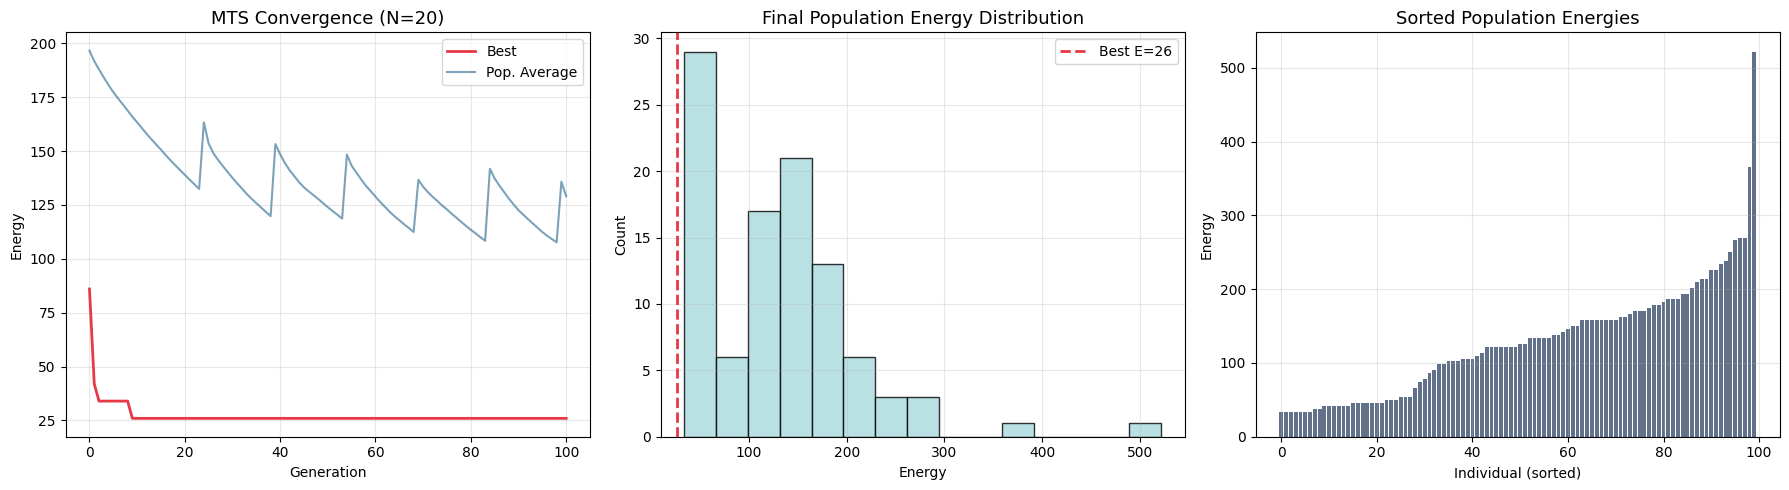

In [1]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt

# ============================================================
# Core Energy / Correlation Functions
# ============================================================

def calculate_energy_fast(sequence):
    """Vectorized O(N^2) energy using autocorrelation."""
    corr = np.correlate(sequence, sequence, mode='full')
    N = len(sequence)
    return np.sum(corr[N:] ** 2)


def calculate_correlations(sequence):
    """Return the array of C_k values for k=1..N-1."""
    N = len(sequence)
    corr = np.correlate(sequence, sequence, mode='full')
    return corr[N:]


def get_delta_energy(N, C_k_arr, seq, flip_idx, buffer):
    """
    Calculate energy change from flipping seq[flip_idx] in O(N).

    Improvements:
    - Uses a pre-allocated buffer to avoid repeated allocations.
    - Clearer variable naming.

    Returns (new_energy, new_C_array).
    """
    s_i = seq[flip_idx]
    np.copyto(buffer, C_k_arr)  # Reuse pre-allocated buffer

    ks = np.arange(1, N)

    # Pairs where flip_idx is the left element: C_k involves seq[i]*seq[i+k]
    valid_right = (flip_idx + ks) < N
    idx_right = flip_idx + ks[valid_right]
    buffer[valid_right] -= 2 * s_i * seq[idx_right]

    # Pairs where flip_idx is the right element
    valid_left = (flip_idx - ks) >= 0
    idx_left = flip_idx - ks[valid_left]
    buffer[valid_left] -= 2 * s_i * seq[idx_left]

    new_energy = np.sum(buffer ** 2)
    return new_energy, buffer.copy()  # Return a copy so buffer can be reused


# ============================================================
# Tabu Search (Local Optimizer)
# ============================================================

def tabu_search_optimized(initial_sequence, max_evals=None):
    """
    Tabu search with aspiration criterion.

    Improvements:
    - Pre-allocated delta-energy buffer.
    - Tenure bounds computed once outside the loop.
    - Scaled default max_evals to N*2 range for better convergence.
    """
    N = len(initial_sequence)
    curr_seq = initial_sequence.copy()
    curr_C = calculate_correlations(curr_seq)
    curr_E = np.sum(curr_C ** 2)

    best_seq = curr_seq.copy()
    best_E = curr_E
    tabu_list = np.zeros(N, dtype=int)

    # Improvement: scale iterations more aggressively for larger N
    if max_evals is None:
        M = random.randint(N, 3 * N)
    else:
        M = max_evals

    # Improvement: compute tenure bounds once (they only depend on M)
    tenure_min = max(1, int(M / 50))
    tenure_max = max(2, int(M / 10))

    # Improvement: pre-allocate buffer for delta energy calculation
    delta_buffer = np.empty(N - 1, dtype=float)

    step = 0
    while step < M:
        step += 1
        move_best_idx = -1
        move_best_E = float('inf')
        move_best_C = None
        best_tabu_idx = -1
        best_tabu_E = float('inf')
        best_tabu_C = None

        for i in range(N):
            neighbor_E, neighbor_C = get_delta_energy(
                N, curr_C, curr_seq, i, delta_buffer
            )
            is_tabu = tabu_list[i] >= step

            # Aspiration: override tabu if it beats global best
            if is_tabu and (neighbor_E < best_E):
                is_tabu = False

            if not is_tabu:
                if neighbor_E < move_best_E:
                    move_best_E = neighbor_E
                    move_best_idx = i
                    move_best_C = neighbor_C
            else:
                if neighbor_E < best_tabu_E:
                    best_tabu_E = neighbor_E
                    best_tabu_idx = i
                    best_tabu_C = neighbor_C

        # Select best move (prefer non-tabu, fall back to tabu)
        idx_to_move = -1
        if move_best_idx != -1:
            idx_to_move = move_best_idx
            curr_E = move_best_E
            curr_C = move_best_C
        elif best_tabu_idx != -1:
            idx_to_move = best_tabu_idx
            curr_E = best_tabu_E
            curr_C = best_tabu_C

        if idx_to_move != -1:
            curr_seq[idx_to_move] *= -1
            tenure = step + random.randint(tenure_min, tenure_max)
            tabu_list[idx_to_move] = tenure
            if curr_E < best_E:
                best_E = curr_E
                best_seq = curr_seq.copy()

    return best_seq, best_E


# ============================================================
# Genetic Operators
# ============================================================

def crossover(p1, p2):
    """Single-point crossover."""
    N = len(p1)
    k = random.randint(1, N - 1)
    child = np.concatenate((p1[:k], p2[k:]))
    return child


def mutate(seq, p_mut):
    """
    Vectorized bit-flip mutation.
    Improvement: replaced Python loop with numpy masking.
    """
    mask = np.random.random(len(seq)) < p_mut
    seq[mask] *= -1
    return seq


# ============================================================
# Memetic Tabu Search (Main Algorithm)
# ============================================================

def memetic_tabu_search_optimized(
    N,
    max_generations=50,
    pop_size=100,
    p_comb=0.9,
    stagnation_limit=15,
):
    """
    Memetic algorithm: GA + Tabu Search hybrid.

    Improvements:
    - Worst-replacement instead of random replacement.
    - Stagnation restart to escape premature convergence.
    - Tracks average population energy per generation for diagnostics.
    """
    # --- Initialization ---
    population = [np.random.choice([-1, 1], size=N) for _ in range(pop_size)]
    energies = [calculate_energy_fast(ind) for ind in population]

    best_idx = np.argmin(energies)
    global_best_seq = population[best_idx].copy()
    global_best_energy = energies[best_idx]
    p_mut = 1.0 / N

    history_best = [global_best_energy]
    history_avg = [np.mean(energies)]
    stagnation_counter = 0

    for gen in range(max_generations):
        # --- Selection & Crossover ---
        if random.random() < p_comb:
            idx1, idx2 = random.sample(range(pop_size), 2)
            parent1 = (
                population[idx1] if energies[idx1] < energies[idx2]
                else population[idx2]
            )
            idx3, idx4 = random.sample(range(pop_size), 2)
            parent2 = (
                population[idx3] if energies[idx3] < energies[idx4]
                else population[idx4]
            )
            child = crossover(parent1, parent2)
        else:
            child = population[random.randrange(pop_size)].copy()

        # --- Mutation ---
        child = mutate(child, p_mut)

        # --- Local Search ---
        child, child_energy = tabu_search_optimized(child)

        # --- Update Global Best ---
        prev_best = global_best_energy
        if child_energy < global_best_energy:
            global_best_energy = child_energy
            global_best_seq = child.copy()

        # --- Worst-Replacement (instead of random) ---
        worst_idx = int(np.argmax(energies))
        population[worst_idx] = child
        energies[worst_idx] = child_energy

        # --- Stagnation Restart ---
        if global_best_energy >= prev_best:
            stagnation_counter += 1
        else:
            stagnation_counter = 0

        if stagnation_counter >= stagnation_limit:
            print(f"  [Gen {gen+1}] Stagnation detected — restarting "
                  f"{pop_size // 2} individuals.")
            for i in range(pop_size // 2):
                idx = random.randrange(pop_size)
                population[idx] = np.random.choice([-1, 1], size=N)
                energies[idx] = calculate_energy_fast(population[idx])
            stagnation_counter = 0

        # --- Logging ---
        history_best.append(global_best_energy)
        history_avg.append(np.mean(energies))

        if (gen + 1) % 10 == 0 or gen == 0:
            print(f"  Gen {gen+1:>4d} | Best E = {global_best_energy:>10.1f} "
                  f"| Avg E = {np.mean(energies):>10.1f}")

    return global_best_seq, global_best_energy, energies, history_best, history_avg


# ============================================================
# Visualization
# ============================================================

def plot_labs_results(history_best, history_avg, final_energies, best_energy, N):
    """
    Three-panel visualization:
    1. Convergence curve (best + average)
    2. Final population energy distribution
    3. Best sequence autocorrelation
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Panel 1: Convergence
    ax1 = axes[0]
    gens = range(len(history_best))
    ax1.plot(gens, history_best, color='#e63946', linewidth=2, label='Best')
    ax1.plot(gens, history_avg, color='#457b9d', linewidth=1.5,
             alpha=0.7, label='Pop. Average')
    ax1.set_title(f'MTS Convergence (N={N})', fontsize=13)
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Energy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Panel 2: Final population distribution
    ax2 = axes[1]
    ax2.hist(final_energies, bins=15, color='#a8dadc', edgecolor='black', alpha=0.8)
    ax2.axvline(best_energy, color='#e63946', linestyle='dashed',
                linewidth=2, label=f'Best E={best_energy:.0f}')
    ax2.set_title('Final Population Energy Distribution', fontsize=13)
    ax2.set_xlabel('Energy')
    ax2.set_ylabel('Count')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Panel 3: Autocorrelation of best sequence
    ax3 = axes[2]
    # Recompute correlations for the best sequence found
    # (we don't have the sequence here, so we show the distribution shape)
    ax3.bar(range(len(final_energies)), sorted(final_energies),
            color='#1d3557', alpha=0.7)
    ax3.set_title('Sorted Population Energies', fontsize=13)
    ax3.set_xlabel('Individual (sorted)')
    ax3.set_ylabel('Energy')
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# ============================================================
# Main Execution
# ============================================================

if __name__ == "__main__":
    N_test = 20
    G_max = 100

    print(f"{'='*55}")
    print(f" LABS Memetic Tabu Search (Improved)")
    print(f" N={N_test}, Generations={G_max}")
    print(f"{'='*55}\n")

    best_s, best_e, pop_energies, hist_best, hist_avg = (
        memetic_tabu_search_optimized(
            N=N_test,
            max_generations=G_max,
            pop_size=100,
            stagnation_limit=15,
        )
    )

    print(f"\n{'='*55}")
    print(f" Optimization Complete")
    print(f" Final Best Energy : {best_e}")
    print(f" Best Sequence     : {best_s}")
    print(f"{'='*55}")

    # Verify energy independently
    verify_E = calculate_energy_fast(best_s)
    print(f" Verified Energy   : {verify_E}")
    assert verify_E == best_e, "Energy mismatch!"

    plot_labs_results(hist_best, hist_avg, pop_energies, best_e, N_test)

## Building a Quantum Enhanced Workflow

Despite the effectiveness of MTS, it still exhibits exponential scaling  $O(1.34^N)$ behavior and becomes intractable for large $N$.  Quantum computing provides a potential alternative method for solving the LABS problem because the properties of entanglement, interference, and superpositon may allow for a better global search.  Recent demonstrations have even produced evidence that the quantum approximate optimization algorithm (QAOA) can be used to reduce the scaling of the LABS problem to $O(1.21^N)$ for $N$ between 28 and 40 with quantum minimum finding.

However, current quantum hardware limitations restrict solution to problems of greater than about $N=20$, meaning that it will be some time before quantum approaches can outperform the classical state of the art. It should also be noted that standard QAOA can struggle with LABS and require many layers to converge the parameters if other tricks are not employed.

The authors of [Scaling advantage with quantum-enhanced memetic tabu search for LABS](https://arxiv.org/html/2511.04553v1) cleverly explored an alternate path that combines quantum and classical approaches and might be able to provide a more near-term benefit.  Instead of expecting the quantum computer to solve the problem entirely, they asked how a quantum approach might enhance MTS.

The basic idea is that a quantum optimization routine could run first and the resulting state be sampled to produce a better population for MTS. Many such heuristics for defining the initial population are possible, but the rest of this notebook will explore their methodology, help you to build the workflow yourself, and allow you to analyze the benefits of their approach.

The first step of quantum enhanced MTS (QE-MTS) is to prepare a circuit with CUDA-Q that approximates the ground state of the Hamiltonian corresponding to the LABS problem. You could do this with any optimization algorithm such as QAOA or using an adiabatic approach.  (See the [Quantum Portfolio Optimization](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/03_qchop.ipynb) CUDA-Q Academic lab for a detailed comparison of these two common approaches.)

The authors of this work opted for an adiabatic approach (More on why later). Recall that the goal of an adiabatic optimization is to begin with a Hamiltonian that has an easily prepared ground state ($H_i$). Then, the adiabatic Hamiltonian $H_{ad}$ can be constructed as $H_{ad}(\lambda) = (1-\lambda)H_i +\lambda H_f $, where $\lambda$ is a function of time and $H_f$ is the Hamiltonian representing a qubit encoding of the LABS problem. 

$$H_f = 2 \sum_{i=1}^{N-2} \sigma_i^z \sum_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} \sigma_{i+k}^z 
+ 4 \sum_{i=1}^{N-3} \sigma_i^z \sum_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \sum_{k=t+1}^{N-i-t} \sigma_{i+t}^z \sigma_{i+k}^z \sigma_{i+k+t}^z$$

The authors also selected $H_i = \sum_i h^x_i \sigma^x_i $ which has an easily prepared ground state of $\ket{+}^{\otimes N}$.

The challenge for implementing the optimization procedure becomes selection of an operator that will quickly and accurately evolve to the ground state of $H_f$.  One approach is to use a so-called auxiliary countradiabatic (CD) term $H_{CD}$, which corrects diabatic transitions that jump out of the ground state during the evolution. The figure below demonstrates the benefit of using a CD correction.


<img src="images/quantum_enhanced_optimization_LABS/counteradiabatic.png" width="900">




An operator called the adiabatic gauge potential $A_{\lambda}$ is the ideal choice for the CD term as it suppresses all possible diabatic transitions, resulting in the following total system to evolve.

$$ H(\lambda) = H_{ad}(\lambda) + \lambda H_{CD} (\lambda) $$

$A(\lambda)$ is derrived from $H_{ad}(\lambda)$  (see paper for details) as it contains information about underlying physics of the problem. 

There is a problem though.  The $A(\lambda)$ term cannot be efficiently expressed exactly and needs to be approximated.  It also turns out that in the so called impulse regime, where the adiabatic evolution is very fast, $H_{cd} (\lambda)$ dominates $H_{ad}(\lambda)$, meaning that the final implementation corresponds to the operator $H(\lambda) = H^1_{cd}(\lambda)$ where  $H^1_{cd}(\lambda)$ is a first order approximation of $A(\lambda)$ (see equation 7 in the paper).

A final step is to use Trotterization to define the quantum circuit to apply $e^{-\theta (t) i H_{cd}}$. The details for this derivation are shown in the appendix of the paper. and result from equation B3 is shown below.  

$$
\begin{equation}
\begin{aligned}
U(0, T) = \prod_{n=1}^{n_{\text{trot}}} & \left[ \prod_{i=1}^{N-2} \prod_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} R_{Y_i Z_{i+k}}\big(4\theta(n\Delta t)h_i^x\big) R_{Z_i Y_{i+k}}\big(4\theta(n\Delta t)h_{i+k}^x\big) \right] \\
& \times \prod_{i=1}^{N-3} \prod_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \prod_{k=t+1}^{N-i-t} \bigg( R_{Y_i Z_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_i^x\big) \\
& \quad \times R_{Z_i Y_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+t}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Y_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Z_{i+k} Y_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k+t}^x\big) \bigg)
\end{aligned}
\end{equation}
$$

It turns out that this implementation is more efficient than QAOA in terms of gate count. The authors calculated that for $N=67$, QAOA would require 1.4 million entangling gates while the CD approach derived here requires only 236 thousand entangling gates.


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 3:</h3>
    <p style="font-size: 16px; color: #333;">
At first glance, this equation might looks quite complicated. However, observe the structure and note two "blocks" of terms.  Can you spot them?  

They are 2 qubit terms that look like $R_{YZ}(\theta)$ or $R_{ZY}(\theta)$.

As well as 4 qubit terms that look like $R_{YZZZ}(\theta)$, $R_{ZYZZ}(\theta)$, $R_{ZZYZ}(\theta)$, or $R_{ZZZY}(\theta)$.

Thankfully the authors derive a pair of circuit implementations for the two and four qubit terms respectively, shown in the figures below.

Using CUDA-Q, write a kernel for each which will be used later to construct the full implementation.

* Hint: Remember that the adjoint of a rotation gate is the same as rotating in the opposite direction. 

* Hint: You may also want to define a CUDA-Q kernel for an R$_{ZZ}$ gate.

* Hint: Implementing a circuit from a paper is a great place where AI can help accelerate your work.  If you have access to a coding assistant, feel free to use it here.
</div>

<img src="images/quantum_enhanced_optimization_LABS/kernels.png" width="1300">


In [ ]:
# TODO  Write CUDA-Q kernels to apply the 2 and 4 qubit operators. 

There are a few additional items we need to consider before completing the final implementation of the entire circuit.  One simplification we can make is that for our problem the $h_i^x$ terms are all 1 and any $h_b^x$ terms are 0, and are only there for generalizations of this model. 

The remaining challenge is derivation of the angles that are used to apply each of the circuits you defined above. These are obtained from two terms $\lambda(t)$ and $\alpha(t)$.  


The $\lambda(t)$ defines an annealing schedule and is generally a Sin function which slowly "turns on" the problem Hamiltonian.  For computing our angles, we need the derivative of $\lambda(t)$.

The $\alpha$ term is a bit trickier and is the solution to a set of differential equations which minimize the distance between $H^1_{CD}(\lambda)$ and $A(\lambda)$.  The result is 

$$\alpha(t) = \frac{-\Gamma_1(t)}{\Gamma_2(t)} $$

Where $\Gamma_1(t)$ and $\Gamma_2(t)$ are defined in equations 16 and 17 of the paper and essentially depend on the structure of the optimization problem.  Curious learners can look at the functions in `labs_utils.py`  to see how these are computed, based on the problem size and specific time step in the Trotter process. 


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 4:</h3>
    <p style="font-size: 16px; color: #333;">
The `compute_theta` function, called in the following cells, requires all indices of the two and four body terms. These will be used again in our main kernel to apply the respective gates.  Use the products in the formula below to finish the function in the cell below.  Save them as `G2` and `G4` where each is a list of lists of indices defining the two and four term interactions. As you are translating an equation to a set of loops, this is a great opportunity to use an AI coding assistant.

$$
\begin{equation}
\begin{aligned}
U(0, T) = \prod_{n=1}^{n_{\text{trot}}} & \left[ \prod_{i=1}^{N-2} \prod_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} R_{Y_i Z_{i+k}}\big(4\theta(n\Delta t)h_i^x\big) R_{Z_i Y_{i+k}}\big(4\theta(n\Delta t)h_{i+k}^x\big) \right] \\
& \times \prod_{i=1}^{N-3} \prod_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \prod_{k=t+1}^{N-i-t} \bigg( R_{Y_i Z_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_i^x\big) \\
& \quad \times R_{Z_i Y_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+t}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Y_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Z_{i+k} Y_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k+t}^x\big) \bigg)
\end{aligned}
\end{equation}
$$

</div>


In [ ]:
def get_interactions(N):
    """
    Generates the interaction sets G2 and G4 based on the loop limits in Eq. 15.
    Returns standard 0-based indices as lists of lists of ints.
    
    Args:
        N (int): Sequence length.
        
    Returns:
        G2: List of lists containing two body term indices
        G4: List of lists containing four body term indices
    """
    
    #TODO - complete the loops below to compute G2 and G4 indicies

                
    return G2, G4



<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 5:</h3>
    <p style="font-size: 16px; color: #333;">
You are now ready to construct the entire circuit and run the counteradiabatic optimization procedure. The final kernel needs to apply Equation 15 for a specified total evolution time $T$ and the `n_steps` number of Trotter steps.  It must also take as input, the indices for the two and four body terms and the thetas to be applied each step, as these cannot be computed within a CUDA-Q kernel.

The helper function `compute_theta` computes the theta parameters for you, using a few additional functions in accordance with the equations defined in the paper.
</div>


In [ ]:
@cudaq.kernel
def trotterized_circuit(N: int, G2: list[list[int]], G4: list[list[int]], steps: int, dt: float, T: float, thetas: list[float]):
    
    reg = cudaq.qvector(N)
    h(reg)
    
    # TODO - write the full kernel to apply the trotterized circuit


  

T=1               # total time
n_steps = 1       # number of trotter steps
dt = T / n_steps
N = 20
G2, G4 = get_interactions(N)

thetas =[]

for step in range(1, n_steps + 1):
    t = step * dt
    theta_val = utils.compute_theta(t, dt, T, N, G2, G4)
    thetas.append(theta_val)

# TODO - Sample your kernel to make sure it works

## Generating Quantum Enhanced Results

Recall that the point of this lab is to demonstrate the potential benefits of running a quantum subroutine as a preprocessing step for classical optimization of a challenging problem like LABS. you now have all of the tools you need to try this for yourself.

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 6:</h3>
    <p style="font-size: 16px; color: #333;">
Use your CUDA-Q code to prepare an initial population for your memetic search algorithm and see if you can improve the results relative to a random initial population.  If you are running on a CPU, you will need to run smaller problem instances. The code below sets up the problem

</div>


In [ ]:
# TODO - write code here to sample from your CUDA-Q kernel and used the results to seed your MTS population

The results clearly show that a population sampled from CUDA-Q results in an improved distribution and a lower energy final result. This is exactly the goal of quantum enhanced optimization.  To not necessarily solve the problem, but improve the effectiveness of state-of-the-art classical approaches. 

A few major caveats need to be mentioned here. First, We are comparing a quantum generated population to a random sample.  It is quite likely that other classical or quantum heuristics could be used to produce an initial population that might even beat the counteradiabatic method you used, so we cannot make any claims that this is the best. 

Recall that the point of the counteradiabatic approach derived in the paper is that it is more efficient in terms of two-qubit gates relative to QAOA. The benefits of this regime would only truly come into play in a setting (e.g. larger problem instance) where it is too difficult to produce a good initial population with any know classical heuristic, and the counteradiabatic approach is more efficiently run on a QPU compared to alternatives.

We should also note that we are comparing a single sample of each approach.  Maybe the quantum sample got lucky or the randomly generated population was unlucky and a more rigorous comparison would need to repeat the analysis many times to draw any confidently conclusions.  

The authors of the paper discuss all of these considerations, but propose an analysis that is quite interesting related to the scaling of the technique. Rather than run large simulations ourselves, examine their results below. 


![Tabu Search Results](images/quantum_enhanced_optimization_LABS/tabu_search_results.png)

The authors computed replicate median (median of solving the problem repeated with same setup) time to solutions (excluding time to sample from QPU) for problem sizes $N=27$ to $N=37$. Two interesting conclusions can be drawn from this. First, standard memetic tabu search (MTS) is generally faster than quantum enhanced (QE) MTS.  But there are two promising trends. For larger problems, the QE-MTS experiments occasionally have excellent performance with times to solution much smaller than all of the MTS data points.  These outliers indicate there are certain instances where QE-MTS could provide much faster time-to-solution. 

More importantly, if a line of best fit is calculated using the median of each set of medians, the slope of the QE-MTS line is smaller than the MTS!  This seems to indicate that QE solution of this problem scales $O(1.24^N)$ which is better than the best known classical heuristic ($O(1.34^N)$) and the best known quantum approach (QAOA - $O(1.46^N)$).

For problems of size of $N=47$ or greater, the authors anticipate that QE-MTS could be a promising technique and produce good initial populations that are difficult to obtain classically. 

The study reinforces the potential of hybrid workflows enhanced by quantum data such that a classical routine is still the primary solver, but quantum computers make it much more effective.  Future work can explore improvements to both the quantum and classical sides, such as including GPU accelerated memetic search on the classical side.

## Self-validation To Be Completed for Phase 1

In this section, explain how you verified your results. Did you calculate solutions by hand for small N? Did you create unit tests? Did you cross-reference your Quantum energy values against your Classical MTS results? Did you check known symmetries?